In [8]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARMA
import warnings
from itertools import product
from datetime import datetime, timedelta
import calendar

In [9]:
# 数据加载
df = pd.read_excel('Prices.xlsx')

In [10]:
df.head()

,时间(年-月),供给(元/㎡),关注(元/㎡),价值(元/㎡),供给(万元),关注(万元),供给(套),供给(㎡),关注(㎡),供给(年),关注(年)
0,2019-03-01,65253,62880,34250,753.5,792.6,57090,114.12,124.92,57,64
1,2019-02-01,65473,58102,34408,747.3,631.0,37322,114.05,101.50,57,66
2,2019-01-01,64663,57958,33774,730.2,594.3,42247,113.87,100.42,57,49
3,2018-12-01,63405,55919,33193,753.9,681.5,42976,116.33,119.57,57,55
4,2018-11-01,62298,72462,32983,745.4,931.0,42078,117.05,122.35,57,64


In [11]:
df = df[['时间(年-月)', '供给(元/㎡)']]
df.rename(columns = {"时间(年-月)": "Timestamp",'供给(元/㎡)':"Price"},inplace=True)

In [13]:
df.head()

,Timestamp,Price
0,2019-03-01,65253
1,2019-02-01,65473
2,2019-01-01,64663
3,2018-12-01,63405
4,2018-11-01,62298


In [14]:
# 将时间作为df的索引
df.Timestamp = pd.to_datetime(df.Timestamp)
df.index = df.Timestamp

In [15]:
# 按照月，季度，年来统计
df_month = df.resample('M').mean()
df_Q = df.resample('Q-DEC').mean()
df_year = df.resample('A-DEC').mean()

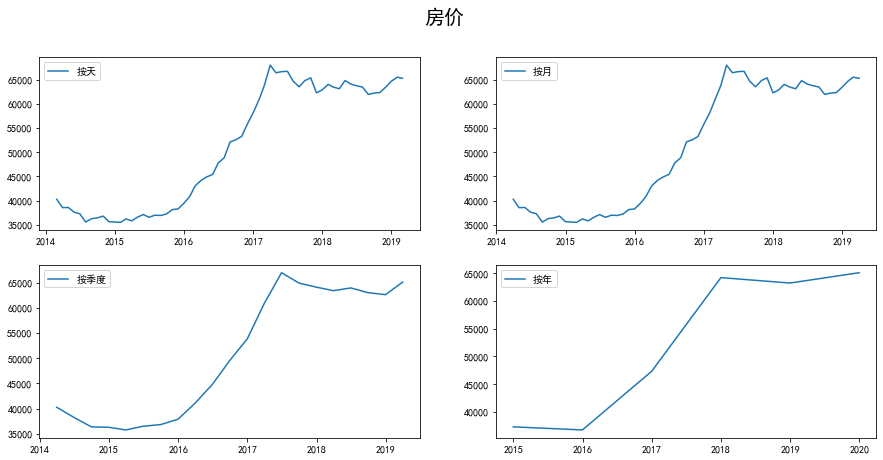

In [16]:
# 按照天，月，季度，年来显示房价的走势
fig = plt.figure(figsize=[15, 7])
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.suptitle('房价', fontsize=20)
plt.subplot(221)
plt.plot(df.Price, '-', label='按天')
plt.legend()
plt.subplot(222)
plt.plot(df_month.Price, '-', label='按月')
plt.legend()
plt.subplot(223)
plt.plot(df_Q.Price, '-', label='按季度')
plt.legend()
plt.subplot(224)
plt.plot(df_year.Price, '-', label='按年')
plt.legend()
plt.show()

In [18]:
# 设置参数范围
ps = range(0, 3)
qs = range(0, 3)
parameters = product(ps, qs)
parameters_list = list(parameters)
# 寻找最优ARMA模型参数，即best_aic最小
results = []
best_aic = float("inf") # 正无穷
for param in parameters_list:
    try:
        model = ARMA(df_month.Price,order=(param[0], param[1])).fit()
    except ValueError:
        print('参数错误:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
# 输出最优模型
print('最优模型: ', best_model.summary())

参数错误: (0, 2)
最优模型:                                ARMA Model Results                              
Dep. Variable:                  Price   No. Observations:                   61
Model:                     ARMA(2, 0)   Log Likelihood                -525.867
Method:                       css-mle   S.D. of innovations           1291.831
Date:                Fri, 08 May 2020   AIC                           1059.734
Time:                        00:45:27   BIC                           1068.178
Sample:                    03-31-2014   HQIC                          1063.043
                         - 03-31-2019                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        5.211e+04   1.02e+04      5.132      0.000    3.22e+04     7.2e+04
ar.L1.Price     1.3681      0.119     11.503      0.000       1.135       1.601
ar.L2.Price    -0.3772      

date_list= [Timestamp('2019-04-30 00:00:00', freq='M'), Timestamp('2019-05-31 00:00:00', freq='M'), Timestamp('2019-06-30 00:00:00', freq='M')]


Text(0, 0.5, '房价')

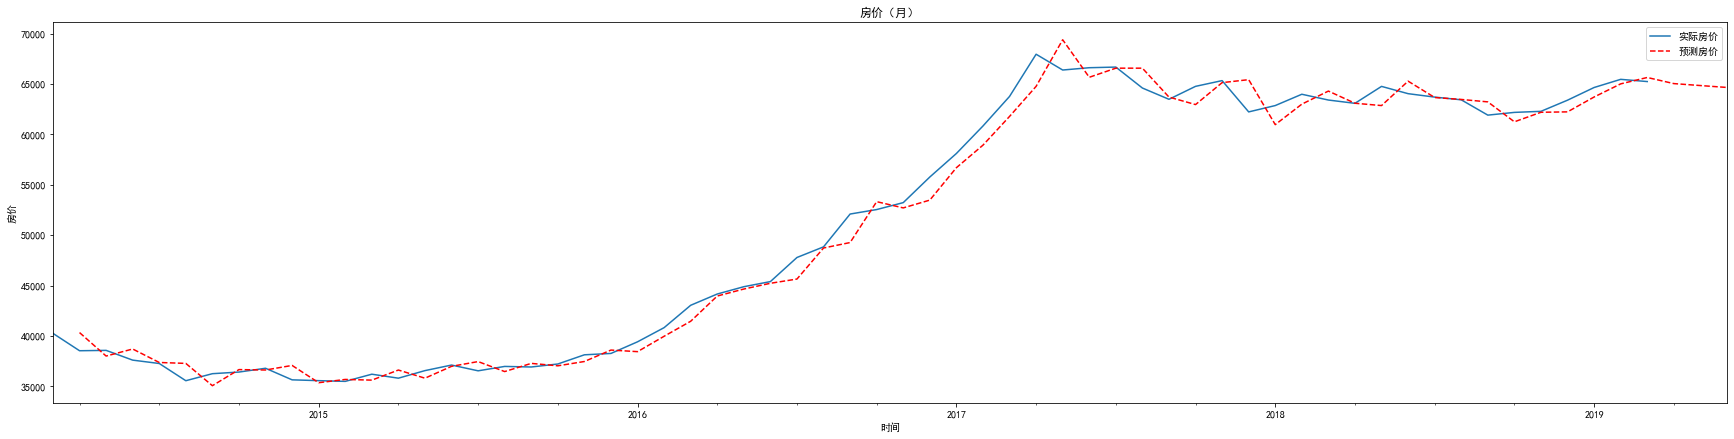

In [20]:
# 设置future_month，需要预测的时间date_list
df_month2 = df_month[['Price']]
future_month = 3
last_month = pd.to_datetime(df_month2.index[len(df_month2)-1])
#print(last_month)
date_list = []
for i in range(future_month):
    # 计算下个月有多少天
    year = last_month.year
    month = last_month.month
    if month == 12:
        month = 1
        year = year+1
    else:
        month = month + 1
    next_month_days = calendar.monthrange(year, month)[1]
    #print(next_month_days)
    last_month = last_month + timedelta(days=next_month_days)
    date_list.append(last_month)
print('date_list=', date_list)

# 添加未来要预测的3个月
future = pd.DataFrame(index=date_list, columns= df_month.columns)
df_month2 = pd.concat([df_month2, future])
df_month2['forecast'] = best_model.predict(start=0, end=len(df_month2))
# 第一个元素不正确，设置为NaN
df_month2['forecast'][0] = np.NaN

# 房价预测结果显示
plt.figure(figsize=(30,7))
df_month2.Price.plot(label='实际房价')
df_month2.forecast.plot(color='r', ls='--', label='预测房价')
plt.legend()
plt.title('房价（月）')
plt.xlabel('时间')
plt.ylabel('房价')